In [104]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel
from sklearn.preprocessing import OneHotEncoder



In [40]:
np.random.seed(42)

In [42]:
# 2. Load Data
# ===============================
data = pd.read_csv("/Users/sakshighatge/Downloads/german_credit_data 2.csv")


In [44]:
data.shape

(1000, 21)

In [46]:
data.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   laufkont  1000 non-null   int64
 1   laufzeit  1000 non-null   int64
 2   moral     1000 non-null   int64
 3   verw      1000 non-null   int64
 4   hoehe     1000 non-null   int64
 5   sparkont  1000 non-null   int64
 6   beszeit   1000 non-null   int64
 7   rate      1000 non-null   int64
 8   famges    1000 non-null   int64
 9   buerge    1000 non-null   int64
 10  wohnzeit  1000 non-null   int64
 11  verm      1000 non-null   int64
 12  alter     1000 non-null   int64
 13  weitkred  1000 non-null   int64
 14  wohn      1000 non-null   int64
 15  bishkred  1000 non-null   int64
 16  beruf     1000 non-null   int64
 17  pers      1000 non-null   int64
 18  telef     1000 non-null   int64
 19  gastarb   1000 non-null   int64
 20  kredit    1000 non-null   int64
dtypes: int64(21)
memory usage: 164.2 KB


In [80]:
print(data.columns)

Index(['laufkont', 'laufzeit', 'moral', 'verw', 'hoehe', 'sparkont', 'beszeit',
       'rate', 'famges', 'buerge', 'wohnzeit', 'verm', 'alter', 'weitkred',
       'wohn', 'bishkred', 'beruf', 'pers', 'telef', 'gastarb', 'kredit'],
      dtype='object')


In [48]:
# TARGET COLUMN (adjust if named differently)
TARGET = "risk" if "risk" in data.columns else data.columns[-1]

X = data.drop(columns=[TARGET])
y = data[TARGET]

In [50]:
# Map target if needed
if y.dtype == "object":
    y = y.map({"good": 1, "bad": 0})


In [82]:
# 3. Auto-detect Feature Types
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
numerical_cols = X.select_dtypes(exclude=["object", "category"]).columns


In [84]:
# 4. Train / Validation / Test Split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
)


In [86]:
# 5. Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


In [90]:
# 6. Model A – Logistic Regression
model_A = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])


In [92]:
# 7. Model B – Random Forest
model_B = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42
    ))
])

model_A.fit(X_train, y_train)
model_B.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['laufkont', 'laufzeit', 'moral', 'verw', 'hoehe', 'sparkont', 'beszeit',
       'rate', 'famges', 'buerge', 'wohnzeit', 'verm', 'alter', 'weitkred',
       'wohn', 'bishkred', 'beruf', 'pers', 'telef', 'gastarb'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])

In [94]:
# 8. Platt Scaling Calibration
calibrated_B = CalibratedClassifierCV(
    model_B,
    method="sigmoid",
    cv="prefit"
)

calibrated_B.fit(X_val, y_val)


CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   StandardScaler(),
                                                                                   Index(['laufkont', 'laufzeit', 'moral', 'verw', 'hoehe', 'sparkont', 'beszeit',
       'rate', 'famges', 'buerge', 'wohnzeit', 'verm', 'alter', 'weitkred',
       'wohn', 'bishkred', 'beruf', 'pers', 'telef', 'gastarb'],
      dtype='object')),
                                                                                  ('cat',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   Index([], dtype='object'))])),
                                                 ('clf',
                                                  RandomForestClassifier(class_weight='balanced',
                                                                         n_estimators=300,
                                                                         random_state=42))]))

In [96]:
# 9. Threshold Sweep (Validation)
thresholds = np.arange(0.70, 1.00, 0.01)
records = []

prob_B_val = calibrated_B.predict_proba(X_val)[:, 1]
pred_A_val = model_A.predict(X_val)
pred_B_val = (prob_B_val >= 0.5).astype(int)

for tau in thresholds:
    hybrid_preds = np.where(prob_B_val >= tau, pred_B_val, pred_A_val)
    acc = accuracy_score(y_val, hybrid_preds)
    trr = np.mean(prob_B_val < tau)
    records.append((tau, trr, acc))

results_df = pd.DataFrame(records, columns=["tau", "TRR", "accuracy"])


In [98]:
# 10. Select Optimal Threshold τ*
optimal_row = results_df[results_df["TRR"] >= 0.70] \
    .sort_values("accuracy", ascending=False).iloc[0]

tau_star = optimal_row["tau"]

print("Optimal τ*:", tau_star)
print(optimal_row)


Optimal τ*: 0.8800000000000001
tau         0.880000
TRR         0.721854
accuracy    0.708609
Name: 18, dtype: float64


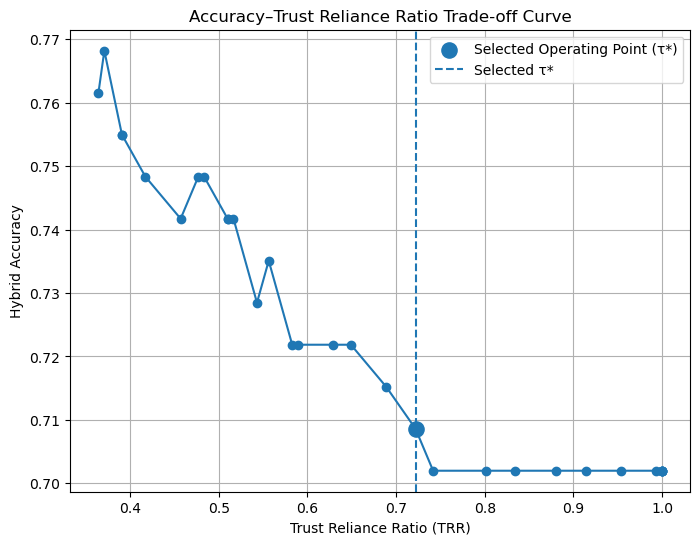

In [76]:
plt.figure(figsize=(8, 6))
plt.plot(results_df["TRR"], results_df["accuracy"], marker="o")

# ADD THIS LINE ⬇️
plt.scatter(
    optimal_row["TRR"],
    optimal_row["accuracy"],
    s=120,
    zorder=5,
    label="Selected Operating Point (τ*)"
)

plt.axvline(x=optimal_row["TRR"], linestyle="--", label="Selected τ*")
plt.xlabel("Trust Reliance Ratio (TRR)")
plt.ylabel("Hybrid Accuracy")
plt.title("Accuracy–Trust Reliance Ratio Trade-off Curve")
plt.legend()
plt.grid(True)
plt.show()


In [100]:
# 11. Final Test Set Evaluation
prob_B_test = calibrated_B.predict_proba(X_test)[:, 1]
pred_A_test = model_A.predict(X_test)
pred_B_test = (prob_B_test >= 0.5).astype(int)

hybrid_test = np.where(prob_B_test >= tau_star, pred_B_test, pred_A_test)

acc_hybrid = accuracy_score(y_test, hybrid_test)
acc_B = accuracy_score(y_test, pred_B_test)

print("Hybrid Accuracy:", acc_hybrid)
print("Model B Accuracy:", acc_B)


Hybrid Accuracy: 0.6933333333333334
Model B Accuracy: 0.8066666666666666


In [102]:
# 12. Paired t-test (Phase 3)
t_stat, p_value = ttest_rel(hybrid_test, pred_B_test)
print("Paired t-test p-value:", p_value)

Paired t-test p-value: 4.265599717397831e-08
